# Do RNN and LSTM have Long Memory?

Authors: Jingyu Zhao, Feiqing Huang, Jia Lv, Yanjie Duan, Zhen Qin, Guodong Li, Guangjian Tian

Published in: 37th International Conference on Machine Learning, 2020

The paper investigates whether Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks truly have long memory—the ability to retain information for a long time. Even though LSTMs were designed to overcome the short memory issue in RNNs, the authors show that both RNNs and LSTMs do not have long memory from a statistical perspective.

## 1. The Problem

In machine learning we usually work with sequential data and the models like RNNs struggle with remembering long-term patterns, due to the vanishing gradient problem - old information fades away as the sequence gets longer and longer. Working with deep learning algorithms usually means working with very big datasets and for the model to forget the first passed data is a big issue. LSTMs are designed to fix this problem, but the researchers in the article are going to question, how truly long term memory does it have.
 
 The article mentions some related past research, that has been conducted on this topic. First it mentions that traditional statistical models can handle long memory well, but are not flexible like neural networks. There are also some researches on LSTM's long term memory, but they are very little count. There have been some alternatives to RNN, that try to keep long term memory. The model from this article will be compared with them.


## 2. Memory property of recurrent networks

### 2.1 What is long memory?

First long memory is defined from a statistical perspective.


The autocovariance function measures how strongly past values influence future values in a time series.

$$\sum_{k=-\infty}^{\infty } \gamma x (k) = \infty \text{ (long memory)} $$

$$0 < \sum_{k=-\infty}^{\infty } \gamma x (k) < \infty \text{ (short memory)} $$

$$where:
\\ X_t \text{ is the time series}
\\ \text{k represents the time lag}
\\ y_x(k) \text{is the autocovariance function, which measures how much past values influence the present}$$

If the sum of the covariances is infinite, the time series has long memory. If the sum is finite, the time series has short memory.

### Why do the models have short memory?

Next up, there is an explanation on how RNN's and LSTM's work and process sequences mathematically. A general recurrent network consists of  inputs (x(t)), hidden states (s(t)) and outputs (y(t)). The model assumes the target sequence as:

$$ y(t)= z(t) + s(t) $$

The network is basically trying to predict y(t) using its internal hidden states.

To analyze the memory of recurrent networks, they are modeles as a Markov Process, which means that the future state depends only on the previous state, not the full history. If an RNN follows this structure, it cannot retain long memory, because old information is lost over time.

Using hidden states allows us to pass along some memory, but they also follow a Markov structure.

In RNN's the hidden state depends only on s(t-1), like in the Markov chains and that makes older information gradually fade away.

LSTM modify the basic RNN structure by adding gates to control memory updates and that way LSTMs can retain information lonjger than RNNs, but their forget gate often remove old information too aggressive and this limits long memory retention.

Next up mathematical proofs are shown, that RNN and LSTM models only have short memory, since both models have update rules, that shrink past data at an exponential rate.

### New way to define long memory in neural networks

A new way to define long memory in neural networks is proposed.
$$
y(t) = \sum_{k=0}^{\infty} A_k x(t-k) + \epsilon(t)
$$


y(t) is the output at time 

x(t−k) is the input from 

k steps in the past.

​Ak  is a weight function that controls how much past data influences the present.

ϵ(t) is a noise term.

The idea with tis memory layer is  to make Ak decrease quickly, in order to achieve long memory and make past inputs have strong influence.

For this we need k to be as high of a value as possible.

$$ 
A_k \sim k^{-d-1} \quad \text{as } k \to \infty, \text{ where } d \in (0, 0.5)
 $$

So the parameter d controls the strength of long memory and we need a small d, to make the memory last longer.

## 3. Long Memory Recurrent Networks

### 3.1 Memory-augmented RNN (MRNN)

$$
F(x(t); d) = \left( (I - B)^d - I \right) x(t)
$$

Above is the memory filter, that the authors introduces for RNN. B is the backshift operator and d is the memory parameter. So the long memory hidden unit is introduced in the hidden state like following:

$$
m(t) = \tanh(W_m m(t-1) + W_x x(t) + b_m)
$$

<img src="./rnn_structure.png" alt="drawing" width="1000"/>

As we can see in the structure, the m(t) is used in parallel with the hidden filter h(t).

$$ z(t) = g(W_{zh} h(t) + W_{zm} m(t) + b_z) + \epsilon(t) $$

The memory parameter d(t) controls how much past information is kept and it is dynamically calculated based on previous memory and hidden states. The use of sigmoid function ensures d(t) is kept in the rage (0, 0.5).

$$ d(t) = \frac{1}{2} \sigma\left(W_d [d(t-1), h(t-1), m(t-1), x(t)] + b_d \right)
 $$

### 3.2 Memory-augmented LSTM (MLSTM)

Normal LSTM has its cell state like this:

$$ c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t $$

The issue is that if ft is small, past informations fades too fast.

So MLSTM replaces the equation with this:

$$ (I - B)_d \, c_t = i_t \odot \tilde{c}_t$$

Instead of simply using forget gates, it smoothly blends past cell states using a fractional memory filter. This gradually forgets older ijnformation.

The memory paramter is calculated dynamically:

$$ d_t = \frac{2}{1} \sigma\left(W_d [d_{t-1}, h_{t-1}, x_t] + b_d \right) $$

And it is applied in the cell state like this:

$$c_t = - \sum_{j=1}^{K} w_j (d_t) c_{t-j} + i_t \odot \tilde{c}_t $$

Finally the hidden state is computed using this formula:

$$ h_t = o_t \odot \tanh(c_t) $$

# TODO explain it

## 4. Experimentation

[*********************100%***********************]  1 of 1 completed



Training RNN...
Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058 - val_loss: 1.1686e-04
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5319e-04 - val_loss: 1.2899e-04
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5871e-04 - val_loss: 1.0841e-04
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4900e-04 - val_loss: 1.0328e-04
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5479e-04 - val_loss: 1.0181e-04
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5374e-04 - val_loss: 1.0352e-04
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5748e-04 - val_loss: 1.1080e-04
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4498e-04 - val_loss: 1.1907e-04
Epoch 9/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5226e-04 - val_loss: 1.0121e-04
Epoch 10/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6718e-04 - val_loss: 1.1884e-04
Epoch 11/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

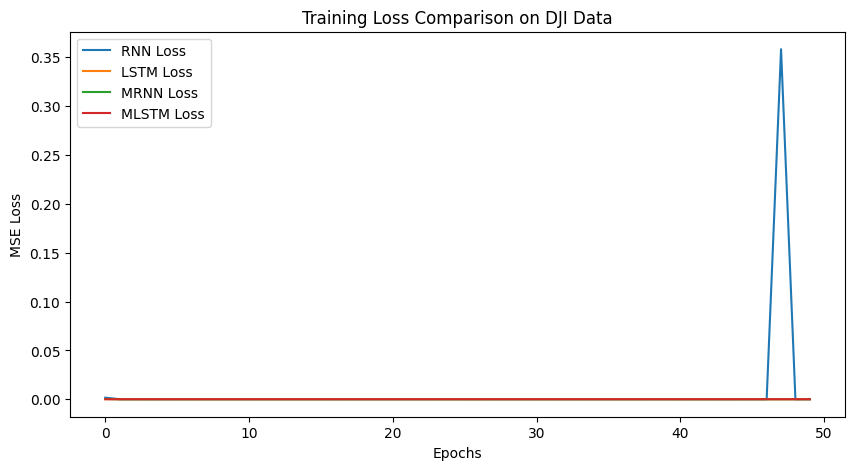

In [1]:
import numpy as np
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Layer, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def fetch_dji_data():
    dji = yf.download('^DJI', start='2000-01-01', end='2023-12-31')
    if 'Close' in dji.columns:
        returns = dji['Close'].pct_change().dropna()
    else:
        raise KeyError("Column 'Close' not found in the dataset.")
    return returns.values

def prepare_data(series, seq_len=20):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

def build_rnn(seq_len):
    inputs = Input(shape=(seq_len, 1))
    x = SimpleRNN(50, activation='tanh', return_sequences=False)(inputs)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

def build_lstm(seq_len):
    inputs = Input(shape=(seq_len, 1))
    x = LSTM(50, activation='tanh', return_sequences=False)(inputs)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

# Custom Memory Filter Layer
class MemoryFilter(Layer):
    def __init__(self, seq_len, **kwargs):
        super(MemoryFilter, self).__init__(**kwargs)
        self.seq_len = seq_len
        self.d = self.add_weight(shape=(1,), initializer='uniform', trainable=True)
    
    def call(self, inputs):
        memory_weights = [tf.math.exp(-self.d * i) for i in range(self.seq_len)]
        memory_weights = tf.expand_dims(memory_weights, axis=0)
        return tf.reduce_sum(inputs * memory_weights, axis=1, keepdims=True)

def build_mrnn(seq_len):
    inputs = Input(shape=(seq_len, 1))
    memory = MemoryFilter(seq_len)(inputs)
    x = SimpleRNN(50, activation='tanh')(memory)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

def build_mlstm(seq_len):
    inputs = Input(shape=(seq_len, 1))
    memory = MemoryFilter(seq_len)(inputs)
    x = LSTM(50, activation='tanh')(memory)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

seq_len = 20
series = fetch_dji_data()
X, y = prepare_data(series, seq_len)
X = X.reshape(-1, seq_len, 1)
y = y.reshape(-1, 1)

models = {
    "RNN": build_rnn(seq_len),
    "LSTM": build_lstm(seq_len),
    "MRNN": build_mrnn(seq_len),
    "MLSTM": build_mlstm(seq_len)
}

histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    histories[name] = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Loss Comparison on DJI Data")
plt.show()
